In [10]:
# Python Standard Libraries for importing data from binary file
import time    #for calculating time

#core packages
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Ellipse


#custom module
from  dataset import load_dataset, train_dev_split, prep_dataset
from dataset import visualize_data_distribution, visualize_dataset

from ffnn import init_layers, init_hyperParams
from ffnn import train, evaluate

from ModelUtils import convert_time
from ModelUtils import save_model, load_model

np.random.seed(1)
%matplotlib inline

In [11]:
dataset_size_in_per = 25

train_x_orig, train_y_orig, test_x_orig, test_y_orig = load_dataset(dataset = "mnist", size_in_per = dataset_size_in_per)

print("Sample Size : %d%%\n"%(dataset_size_in_per))
print("Data\t\t\t","Datatype\t\t","Dataset Size")
print("=================================================================")
print("Training Set Images:\t" + str(type(train_x_orig))+"\t",str(train_x_orig.shape))
print("Training Set Labels:\t" + str(type(train_y_orig))+"\t",str(train_y_orig.shape))
print("Test Set Images:\t" + str(type(test_x_orig))+"\t",str(test_x_orig.shape))
print("Test Set Labels:\t" + str(type(test_y_orig))+"\t",str(test_y_orig.shape))
print("=================================================================")

Sample Size : 25%

Data			 Datatype		 Dataset Size
Training Set Images:	<class 'numpy.ndarray'>	 (15000, 28, 28)
Training Set Labels:	<class 'numpy.ndarray'>	 (15000, 1)
Test Set Images:	<class 'numpy.ndarray'>	 (2500, 28, 28)
Test Set Labels:	<class 'numpy.ndarray'>	 (2500, 1)


In [12]:
train_x_split, train_y_split, dev_x_split, dev_y_split = train_dev_split(train_x_orig, train_y_orig)

print("Data\t\t\t\t","Datatype\t\t","Shape")
print("========================================================================")
print("Training Set Images:\t\t" + str(type(train_x_split))+"\t",str(train_x_split.shape))
print("Training Set Labels:\t\t" + str(type(train_y_split))+"\t",str(train_y_split.shape))
print("Development Set Images:\t\t" + str(type(dev_x_split))+"\t",str(dev_x_split.shape))
print("Development Set Labels:\t\t" + str(type(dev_y_split))+"\t",str(dev_y_split.shape))
print("========================================================================")


Data				 Datatype		 Shape
Training Set Images:		<class 'numpy.ndarray'>	 (12750, 28, 28)
Training Set Labels:		<class 'numpy.ndarray'>	 (12750, 1)
Development Set Images:		<class 'numpy.ndarray'>	 (2250, 28, 28)
Development Set Labels:		<class 'numpy.ndarray'>	 (2250, 1)


In [13]:
train_x_norm, train_y_encoded = prep_dataset(train_x_split, train_y_split, num_class = 10)
dev_x_norm, dev_y_encoded= prep_dataset(dev_x_split, dev_y_split, num_class = 10)
test_x_norm, test_y_encoded = prep_dataset(test_x_orig, test_y_orig, num_class = 10)

print("Data\t\t\t","Before Processing\t","After Processing")
print("=================================================================")
print("Training Set Images:\t" + str(train_x_split.shape)+"\t\t"+ str(train_x_norm.shape))
print("Training Set Labels:\t" + str(train_y_split.shape)+"\t\t"+ str(train_y_encoded.shape))
print("Dev Set Images:\t\t" + str(dev_x_split.shape)+"\t\t"+ str(dev_x_norm.shape))
print("Dev Set Labels:\t\t" + str(dev_y_split.shape)+"\t\t"+ str(dev_y_encoded.shape))
print("Test Set Images:\t" + str(test_x_orig.shape)+"\t\t"+ str(test_x_norm.shape))
print("Test Set Labels:\t" + str(test_y_orig.shape)+"\t\t"+ str(test_y_encoded.shape))
print("=================================================================")

Data			 Before Processing	 After Processing
Training Set Images:	(12750, 28, 28)		(784, 12750)
Training Set Labels:	(12750, 1)		(10, 12750)
Dev Set Images:		(2250, 28, 28)		(784, 2250)
Dev Set Labels:		(2250, 1)		(10, 2250)
Test Set Images:	(2500, 28, 28)		(784, 2500)
Test Set Labels:	(2500, 1)		(10, 2500)


## Random Search 2D

### Random Sampling

In [14]:
def sample_hyperParams(hParam_type, rng, sample_size):

    sample = []
    
    lower_range = rng[0]
    higher_range = rng[1]
    
    
    for i in range(sample_size):
        if hParam_type == "learning_rate":
            r = np.random.uniform(lower_range,higher_range)
            p = 10 ** r
            sample.append(p)
        elif hParam_type == "minibatch_size":
            s = np.random.randint(low = lower_range, high = higher_range)
            sample.append(s)
        else:
            raise ValueError("Sampling of only learning rate and minibatch size is possible for now")
            
    assert(len(sample) == sample_size)
    
    return sample



In [15]:
def calculate_new_search_space(score, samples, score_threshold = 0, summary = True):
    learning_rate = samples["learning_rate"]
    minibatch_size = samples["minibatch_size"]
    
    good_lrs = []
    good_mbs = []
    good_scs = []
    
    if score_threshold == 0:
        top_val = 10
        #if threshold = 0 use the top 10(top_val) best accuracy and their corresponding hyper parameters
        sorted_score_index = [b[0] for b in sorted(enumerate(score),key=lambda i:i[1], reverse = True)]
        good_lrs = [learning_rate[i] for i in sorted_score_index[:top_val]]
        good_mbs = [minibatch_size[i] for i in sorted_score_index[:top_val]]
        good_scs = [score[i] for i in sorted_score_index[:top_val]]
    else:
        #getting the score above the threshold and along with their corresponding hyper parameters
        for ind, val in enumerate(score):
            if val > score_threshold:
                good_lrs.append(learning_rate[ind])
                good_mbs.append(minibatch_size[ind])
                good_scs.append(val)
            
    if len(good_scs) > 1:  
        
        if summary == True:
            print("+================+===============+================+")
            print("| Validation Acc | Learning Rate | Minibatch Size |")
            print("+================+===============+================+")

            for ind,sc in enumerate(good_scs):
                print("| %.5f\t | %.5f\t | %d\t\t  |"%(sc, good_lrs[ind], good_mbs[ind]))

            print("+================+===============+================+")
        
        #calculating the new search range in log form after expanding the learning rate space by 10%
        lr_rng_new = [np.log10(0.9 * min(good_lrs) ), np.log10(1.1 * max(good_lrs))] 

        #calculating the new search range for minibatch size by expanding the search space by 5%
        mbs_rng_new = [0.85 * min(good_mbs), 1.15 * max(good_mbs)] 
        
    else:
        print("No accuracy or only one accuracy beyond threshold was obtained, so range was calculated based on the best score")
        max_lr = learning_rate[np.argmax(score)] 
        
        #calculating the new search range in log form  from the learning rate of best score, expanding by 50 % in each direction
        lr_rng_new = [np.log10(0.5 * max_lr), np.log10(1.5 * max_lr)] #calculating the range in log scale
        
        max_mbs = minibatch_size[np.argmax(score)]
        
        #calculating the new search range from the minibatch size of best score, expanding by 25 % in each direction
        mbs_rng_new = [0.75 * max_mbs, 1.25 * max_mbs] #calculaing the range
        
        
        
    #best hyper parameter combinations
    best_comb = [np.max(score),learning_rate[np.argmax(score)],minibatch_size[np.argmax(score)]]

    if summary == True:
       
        print("New Search Space for Learning Rate: [%.6f,%.6f], log range: [10e%.2f,10e%.2f]"%(10 ** lr_rng_new[0], 10 ** lr_rng_new[1], lr_rng_new[0], lr_rng_new[1]))
        print("New Search Space for Minibatch Size: [%d,%d]"%(mbs_rng_new[0], mbs_rng_new[1]))
        print("Best Score: %.6f "%(best_comb[0]))
        print("Best Hyper Params:\n Learning Rate: %.6f\n Minibatch Size: %d"%(best_comb[1], best_comb[2]))
  
    
    return lr_rng_new, mbs_rng_new, best_comb


In [16]:
def visualize_search(samples,score, lr_rng_new, mbs_rng_new, best_comb,lr_rng_old, mbs_rng_old):
    
    learning_rate = samples["learning_rate"]
    minibatch_size = samples["minibatch_size"]
    lr_min = 10 ** lr_rng_new[0]
    lr_max = 10 ** lr_rng_new[1]
    # plt.style.use('seaborn')
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(10,7))
    #setting ylim based on old range
    ylim_max = 10 ** (int(lr_rng_old[1]))
    if int(lr_rng_old[0]) == lr_rng_old[0]:
        ylim_min = 10 ** (int(lr_rng_old[0])) 
    else:
        ylim_min = 10 ** (int(lr_rng_old[0])-1) 
    
   
    ax.set_ylim(top = ylim_max, bottom = ylim_min)
    
    ax.scatter(minibatch_size,learning_rate, color = "gray",alpha=0.80)
    ax.set_yscale('log')
    ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
    
    rec = Rectangle((mbs_rng_new[0], lr_min), mbs_rng_new[1] - mbs_rng_new[0], lr_max - lr_min, fill=False, edgecolor="green")
    ax.add_patch(rec)

    c = Ellipse((best_comb[2],best_comb[1]),width = 30,  height =0.30 * best_comb[1], edgecolor='green', fill = False, alpha=0.5)
    ax.add_patch(c)
    ax.scatter(best_comb[2],best_comb[1], color = "crimson",alpha=1)


    # Add labels to the plot
    style = dict(size=10, color='blue', alpha = 0.8)
    ax.text(mbs_rng_new[0], lr_max + 0.1*lr_max, "New Search Range ", ha='left', **style)
    ax.text(best_comb[2] + 25, best_comb[1] , "Best Choice ", ha='left', **style)

    
    plt.show()


In [17]:
#Coarse search with 2 epoch, fine search with 5 epoch and detailed search with 10 epoch

def random_search_2D(param1, param2, search_type ="coarse", evaluate_metric = "accuracy", sample_size = 100, search_summary = True, search_visualization = True):
    
    #accessing the input parameter types and their range
    hParam_type1 = param1["hParam type"]
    hParam_range1 = param1["hParam range"]
    
    hParam_type2 = param2["hParam type"]
    hParam_range2 = param2["hParam range"]
    
    samples = {} #for storing the generated samples
    
    #checking the search type
    if search_type == "coarse":
        epoch_size = 2
        score_threshold = 0.95
    elif search_type == "fine":
        epoch_size = 5
        score_threshold = 0.97
    elif search_type == "detail":
        epoch_size = 10
        score_threshold = 0.99
    else:
        raise ValueError("Search Type not identified. Must be 'coarse', 'fine', or 'detail'")
    
    #generating Samples for two input parameters
    samples[hParam_type1] = sample_hyperParams(hParam_type = hParam_type1, rng = hParam_range1, sample_size = sample_size)
    samples[hParam_type2] = sample_hyperParams(hParam_type = hParam_type2,rng = hParam_range2, sample_size = sample_size)
    
            
    if hParam_type1 == "learning_rate":
        leaning_rate_samples =  samples[hParam_type1]
    elif hParam_type2 == "learning_rate":
        leaning_rate_samples =  samples[hParam_type2]
    

    if hParam_type2 == "minibatch_size":
        minibatch_size_samples =  samples[hParam_type2]
    elif hParam_type1 == "minibatch_size":
        minibatch_size_samples =  samples[hParam_type2]
    
        
    score = []
    
    toc = time.time()
        
    for i in range(sample_size):
        print("\nSample: %d/%d -- Learning Rate: %.6f | Minibatch Size: %d"%(i+1,sample_size,leaning_rate_samples[i],minibatch_size_samples[i]))
        print("==========================================================================================================")
        
        hyperParams = init_hyperParams(alpha = leaning_rate_samples[i], num_epoch = epoch_size, minibatch_size = minibatch_size_samples[i], lambd = 0.7,keep_probs = [0.8,0.8,0.8,0.8,0.9])
        
        history = train(train_x_norm, train_y_encoded, dev_x_norm, dev_y_encoded,layers_dim, hyperParams, initialization = "he", optimizer = 'adam',regularizer = None, verbose = 2)
        
        parameters = history["parameters"]
        
        if evaluate_metric == "accuracy":
            dev_acc, _ = evaluate(dev_x_norm, dev_y_encoded,parameters)
            score.append(dev_acc)

        elif evaluate_metric == "f1-score": 
            pass

        else:
            raise ValueError("Metric must be 'accuracy' or 'f1-score'")
        
    print("==========================================================================================================")
    
    tic = time.time() # for calculating entire search time
    hrs, mins, secs , ms = convert_time((tic - toc)*1000)
    
    print("\n\n*************************** Total Search Time = %dhr %dmins %dsecs %.2fms ***************************\n\n"%(hrs, mins, secs, ms))
    
    assert(len(score) == sample_size)
    
    
    
    if search_summary == True:
        print(search_type.capitalize()+" Search Summary: \n")
    
    lr_rng_new, mbs_rng_new, best_comb = calculate_new_search_space(score, samples, score_threshold=0 , summary = search_summary)
    
    if search_visualization == True:
        visualize_search(samples,score,lr_rng_new, mbs_rng_new, best_comb,hParam_range1,hParam_range2)
    
    return lr_rng_new, mbs_rng_new, best_comb


Sample: 1/10 -- Learning Rate: 0.001673 | Minibatch Size: 558
Training The Model...

Epoch 1/2
23/23 [==================== 100%] - 0.18s 8ms/step
Epoch 2/2
23/23 [==================== 100%] - 0.14s 6ms/step

Total Training Time = 0hr 0mins 0secs 493.15ms

Sample: 2/10 -- Learning Rate: 0.008813 | Minibatch Size: 50
Training The Model...

Epoch 1/2
255/255 [==================== 100%] - 0.58s 2ms/step
Epoch 2/2
255/255 [==================== 100%] - 0.56s 2ms/step

Total Training Time = 0hr 0mins 1secs 472.78ms

Sample: 3/10 -- Learning Rate: 0.010370 | Minibatch Size: 333
Training The Model...

Epoch 1/2
39/39 [==================== 100%] - 0.19s 4ms/step
Epoch 2/2
39/39 [==================== 100%] - 0.18s 4ms/step

Total Training Time = 0hr 0mins 0secs 539.15ms

Sample: 4/10 -- Learning Rate: 0.000186 | Minibatch Size: 1047
Training The Model...

Epoch 1/2
13/13 [==================== 100%] - 0.14s 10ms/step
Epoch 2/2
13/13 [==================== 100%] - 0.20s 15ms/step

Total Training Ti

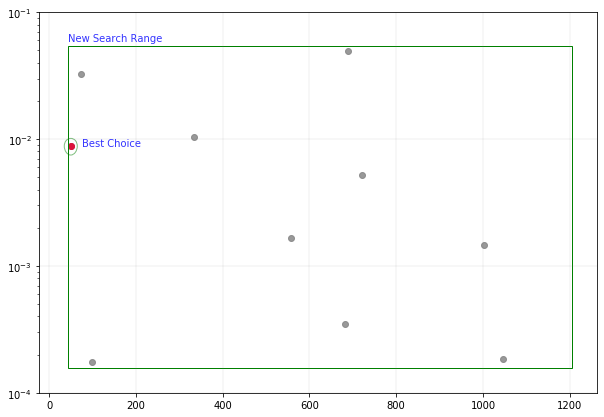

In [18]:
#use larger network with more hidden layers(<=5) and hidden units for better result.
#Note: Larger Network will take more time to tune though the greaning is optimized to greater extend
layers_dim = init_layers(train_x_norm, train_y_encoded, hidden_layers = [128,64])

#Coarse Random Search
lr_rng_coarse = [-4,-1]
mbs_rng_coarse = [10,1050]

param1_coarse = {"hParam type": "learning_rate" ,
          "hParam range": lr_rng_coarse }
    
param2_coarse = {"hParam type": "minibatch_size",
          "hParam range": mbs_rng_coarse } 

#use sample_size >=200 for better tuning
lr_rng_fine, mbs_rng_fine, best_comb = random_search_2D(param1 = param1_coarse, param2 = param2_coarse , search_type ="coarse", evaluate_metric = "accuracy", sample_size = 10, search_summary = True, search_visualization = True)



Sample: 1/10 -- Learning Rate: 0.032475 | Minibatch Size: 500
Training The Model...

Epoch 1/5
26/26 [==================== 100%] - 0.17s 6ms/step
Epoch 2/5
26/26 [==================== 100%] - 0.14s 5ms/step
Epoch 3/5
26/26 [==================== 100%] - 0.14s 5ms/step
Epoch 4/5
26/26 [==================== 100%] - 0.14s 5ms/step
Epoch 5/5
26/26 [==================== 100%] - 0.16s 6ms/step

Total Training Time = 0hr 0mins 1secs 126.68ms

Sample: 2/10 -- Learning Rate: 0.002143 | Minibatch Size: 1063
Training The Model...

Epoch 1/5
12/12 [==================== 100%] - 0.16s 13ms/step
Epoch 2/5
12/12 [==================== 100%] - 0.13s 11ms/step
Epoch 3/5
12/12 [==================== 100%] - 0.12s 10ms/step
Epoch 4/5
12/12 [==================== 100%] - 0.12s 10ms/step
Epoch 5/5
12/12 [==================== 100%] - 0.12s 9ms/step

Total Training Time = 0hr 0mins 1secs 6.15ms

Sample: 3/10 -- Learning Rate: 0.004326 | Minibatch Size: 904
Training The Model...

Epoch 1/5
15/15 [================

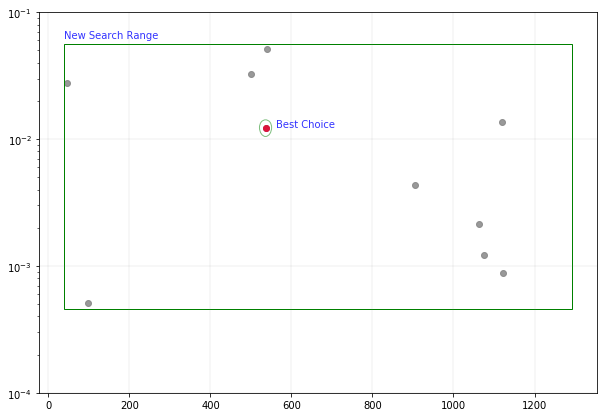

In [20]:
#Fine Random Search

param1_fine = {"hParam type": "learning_rate" ,
          "hParam range": lr_rng_fine }
    
param2_fine = {"hParam type": "minibatch_size",
          "hParam range": mbs_rng_fine } 

#use sample_size >= 200 for better tuning

lr_rng_detail, mbs_rng_detail, best_comb = random_search_2D(param1 = param1_fine, param2 = param2_fine , search_type ="fine", evaluate_metric = "accuracy", sample_size = 10, search_summary = True, search_visualization = True)



Sample: 1/10 -- Learning Rate: 0.001559 | Minibatch Size: 1047
Training The Model...

Epoch 1/10
13/13 [==================== 100%] - 0.15s 11ms/step
Epoch 2/10
13/13 [==================== 100%] - 0.12s 8ms/step
Epoch 3/10
13/13 [==================== 100%] - 0.11s 8ms/step
Epoch 4/10
13/13 [==================== 100%] - 0.12s 9ms/step
Epoch 5/10
13/13 [==================== 100%] - 0.18s 13ms/step
Epoch 6/10
13/13 [==================== 100%] - 0.16s 11ms/step
Epoch 7/10
13/13 [==================== 100%] - 0.13s 10ms/step
Epoch 8/10
13/13 [==================== 100%] - 0.12s 9ms/step
Epoch 9/10
13/13 [==================== 100%] - 0.12s 9ms/step
Epoch 10/10
13/13 [==================== 100%] - 0.13s 9ms/step

Total Training Time = 0hr 0mins 2secs 107.87ms

Sample: 2/10 -- Learning Rate: 0.033921 | Minibatch Size: 1042
Training The Model...

Epoch 1/10
13/13 [==================== 100%] - 0.17s 13ms/step
Epoch 2/10
13/13 [==================== 100%] - 0.17s 13ms/step
Epoch 3/10
13/13 [=========

13/13 [==================== 100%] - 0.16s 12ms/step
Epoch 4/10
13/13 [==================== 100%] - 0.17s 13ms/step
Epoch 5/10
13/13 [==================== 100%] - 0.17s 13ms/step
Epoch 6/10
13/13 [==================== 100%] - 0.15s 11ms/step
Epoch 7/10
13/13 [==================== 100%] - 0.17s 12ms/step
Epoch 8/10
13/13 [==================== 100%] - 0.17s 13ms/step
Epoch 9/10
13/13 [==================== 100%] - 0.18s 13ms/step
Epoch 10/10
13/13 [==================== 100%] - 0.15s 11ms/step

Total Training Time = 0hr 0mins 2secs 664.19ms


*************************** Total Search Time = 0hr 0mins 34secs 99.18ms ***************************


Detail Search Summary: 

+================+===============+================+
| Validation Acc | Learning Rate | Minibatch Size |
+================+===============+================+
| 0.95378	 | 0.00221	 | 168		  |
| 0.95333	 | 0.00060	 | 59		  |
| 0.95111	 | 0.00617	 | 1126		  |
| 0.95067	 | 0.00094	 | 197		  |
| 0.94578	 | 0.01864	 | 1232		  |
| 0.94

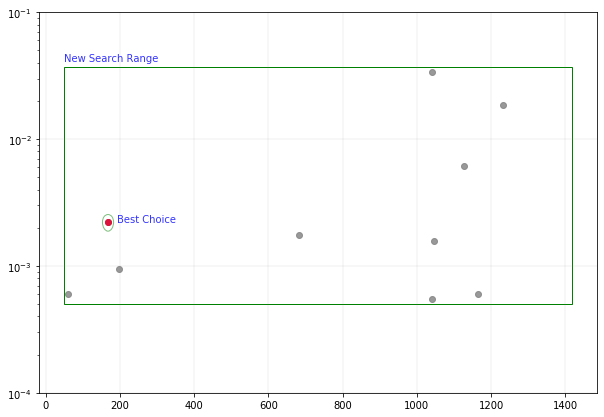

In [21]:
#Detail Random Search

param1_detail = {"hParam type": "learning_rate" ,
          "hParam range": lr_rng_detail }
    
param2_detail = {"hParam type": "minibatch_size",
          "hParam range": mbs_rng_detail } 

#use sample_size >=100 for better tuning

lr_rng_fine, mbs_rng_fine, best_comb = random_search_2D(param1 = param1_detail, param2 = param2_detail , search_type ="detail", evaluate_metric = "accuracy", sample_size = 10, search_summary = True, search_visualization = True)


In [22]:
hyper_params = {"tuned_learning_rate":best_comb[1],
               "tuned_minibatch_size":best_comb[2]}
print(hyper_params)

{'tuned_learning_rate': 0.002212459097887701, 'tuned_minibatch_size': 168}


In [25]:
save_model(file_name = "tunedHyperParameters", model = hyper_params)

In [26]:
loaded_hyper_params = load_model(file_name = "tunedHyperParameters")
print(loaded_hyper_params)

{'tuned_learning_rate': 0.002212459097887701, 'tuned_minibatch_size': 168}


In [27]:
for key,value in loaded_hyper_params.items():
    print(key + ": " + str(value))

tuned_learning_rate: 0.002212459097887701
tuned_minibatch_size: 168
